<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2022_hands_on/blob/main/Week04_follow_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 04 : Follow Up

## Introduction

We got following two questions regarding the hands-on practice on 2022.9.29.

> ***Q1.   In teacher naoya's example "Simple MLP model with the Iris Dataset", what should I do if I want to execute it with GPU?***
>
>A1. This notebook is modified from original "Simple MLP model with the Iris Dataset" so that we can excute it with GPU on Google Colab. Please see [GPU](#gpu) section in this notebook.



> ***Q2.   Can the model of pytorch be visualized? For example, to see the weight of each neuron in it? Or to draw the network structure in the model?***
>
> A2. There are a couple of ways to visualize PyTorch model. Please see [Model Visualization](#model-visualization) section in this notebook.

<a name="gpu"></a>
## GPU
In order to use GPU on Google Colab, we have to change the runtime type as shown below.

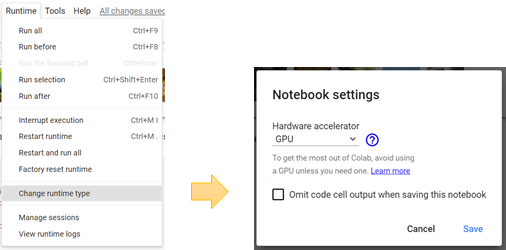

Then we can check if GPU is available. If the code below returns "cuda", we can use GPU on Google Colab. If it returns "cpu", we cannot use GPU for some reasons.



In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


We can check what kind of GPU is assigned now.

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
else:
    print("GPU is not available.")

Tesla T4


In order to perform the model training using GPU, we have to modify some part of the code so that the model and the datasets are loaded on GPU, but not CPU. 

The code in this notebook is modified from the original notebook used in the lecture on 2022.9.29, but some parts are modified so that we can use GPU. Please go through the code in this notebook. The modified parts are shown like,

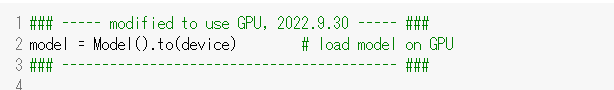

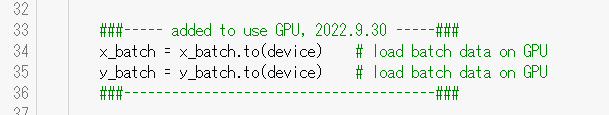

## Data Preparation

First of all, let's import some general Python packages.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns     # data visualization package based on matplotlib

### Iris Dataset

The Iris dataset can be loaded from scikit-learn dataset (`sklearn.datasets`) module. scikit-learn is a very popular machine-learning package in Python. Although scikit-learn is not capable of deep learning, it has lots of useful tools for data processing and analysis for deep learning. We will use scikit-learn often in this lecture.

*   scikit-learn https://scikit-learn.org/stable/
*   Iris dataset https://en.wikipedia.org/wiki/Iris_flower_data_set

In [4]:
from sklearn.datasets import load_iris
iris_data = load_iris()

df_iris = pd.DataFrame(iris_data["data"], columns=iris_data["feature_names"])
df_iris["label"] = iris_data["target"]
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


As shown above, the dataset consisits of 4 feature values (sepal length, sepal width, petal length and petal width) and the label of iris type (target) of 150 samples. 

The label corresponds to one of the three iris types as shown in the table below.

|  label  |  name of iris  |
| :----: | :----: |
|  0  |  setosa  |
|  1  |  versicolor |
| 2| virginica|


### torch.tensor

First we have to convert input and output data to `torch.tensor` so that PyTorch can handle them. Make sure that we set the data type (`dtype`) of `x` as `torch.float32` and `y` as `torch.int64`.

In [5]:
x = torch.tensor(iris_data["data"], dtype=torch.float32)
y = torch.tensor(iris_data["target"], dtype=torch.int64)

### TensorDataset

Then we create `TensorDataset` object named `xy_dataset` from x and y data.

In [6]:
from torch.utils.data import TensorDataset

xy_dataset = TensorDataset(x, y)
len(xy_dataset)

150

### train test split

We prepared `xy_dataset` for training the model. However we should not use all of them for training. 

We have to evaluate the model after the training. ***This evaluation must be done with the dataset not used for training.*** So we need to split all of `xy_dataset` into training data (`xy_train`) and evaluation/testing data (`xy_test`).

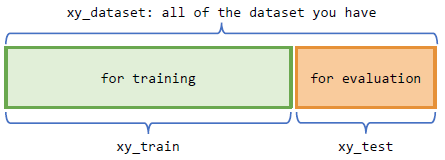

In [7]:
from torch.utils.data import random_split

train_size = 100   # define train_size
test_size = 50     # define test_size

# randomly split xy_dataset into xy_train and xy_test
xy_train, xy_test = random_split(xy_dataset, [train_size, test_size])

# check length of xy_train and xy_test
print("xy_train", len(xy_train))
print("xy_test", len(xy_test))

xy_train 100
xy_test 50


### Data Loader

In order to feed the data to the model for training, we create `DataLoader`objects named `train_loader` and `test_loader`. 

Here we set the parameter of `batch_size=5`. This means we feed every 5 sets of input and output data to the model. Since the total amount of Iris dataset is not very big, we can actually feed all of the data to the model at once. But as we will see in the future, deep neural network models are traind with huge amount of data in many cases. In such cases it is not possible to feed those data at the same time because of limitation of memories. Also we can choose to shuffle the oder of the data or not. For most of the cases it is good to shuffle data for training.

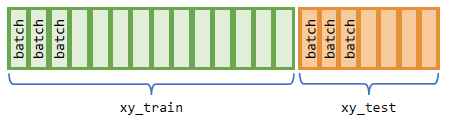

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(xy_train, batch_size=5, shuffle=True)
test_loader = DataLoader(xy_test, batch_size=5, shuffle=False)

That's it for data preparation!

## Building a Model

### Model Architecture

Next step is to build a neural network model. 

Here we are going to define a MLP model which consists of only three layers (input, hidden, output). The input layer has four neurons because we will feed four feature values there. The hidden layer can have any number of neurons. The output layer has three neurons which correspond to the number of iris types. The neuron with highest value among three neurons indicates the most probable iris type that the model predicted.

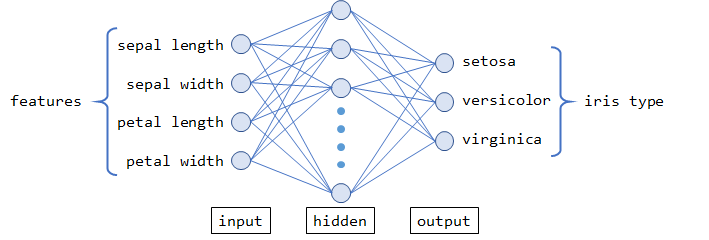

In [9]:
import torch.nn as nn

# define a custom class named "Model"
class Model(nn.Module):

    # Constructor
    def __init__(self):                 # do not change
        super(Model, self).__init__()   # do not change

        # define a network named "classifier"
        self.classifier = nn.Sequential(
            nn.Linear(in_features=4, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=3)
        )
    
    # Instance method
    def forward(self, x):        # do not change
        x = self.classifier(x)
        return x

model = Model()    # construct an instance of the Model class
print(model)

Model(
  (classifier): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)


## Training

### Loss Function

During the training we have to know the "loss" value which indicates how wrong the current model prediction is. To measure the loss value quantitatively, we can use loss functions. The cross-entropy loss function (`nn.CrossEntropyLoss()`) is usually used for classification tasks.


* `nn.CrossEntropyLoss()` https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [10]:
loss_func = nn.CrossEntropyLoss()

According to the link above, the cross-entroly loss is determined by the equation below, where $p_i$ is prediction (output value of the model) for the $i_{th}$ category and $p_y$ is prediction for the ground truth label.  

$\displaystyle \mathrm{loss} =  -\ln\left(\exp(p_y)/\sum_{i=0}^{n-1} \exp(p_i)\right) = -p_y + \ln\left(\sum_{i=0}^{n-1} \exp(p_i)\right)$

### Optimizer

During the model training process, the model parameters (weights and biases) are updated in order to minimize the loss value. Algorithms for updating the model parameters are called optimizers. We use so-called "Adam" optmizer here, but there are several different optimizers. The parameter `lr` is learning rate that controls how much to change the model parameters in respose to the loss value.

* `optim.Adam()` https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam

In [11]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### Training Loop

Now we are ready for training the model. The code for training process is a bit long. But most part of the training processes is common for other datasets and models, therefore once you get used to it, it won't be a big deal anymore.

The main components of training loop are shown below.







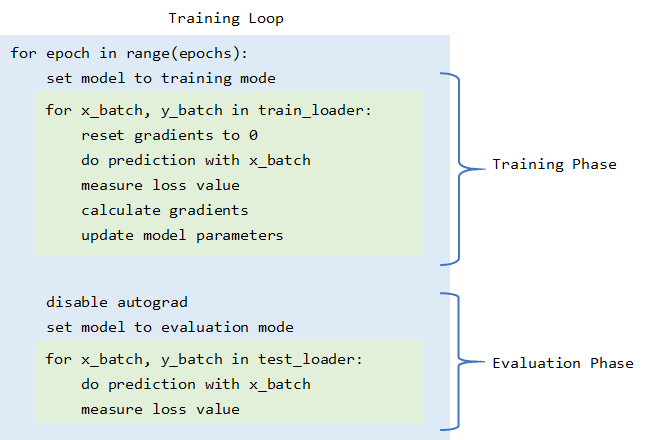

In [12]:
### ----- modified to use GPU, 2022.9.30 ----- ###
model = Model().to(device)        # load model on GPU
### ------------------------------------------ ###        

loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer


epochs = 50  # set total epochs

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

# training loop
for epoch in range(epochs):

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    for x_batch, y_batch in train_loader:      # take mini batch data from train_loader

        ###----- added to use GPU, 2022.9.30 -----###
        x_batch = x_batch.to(device)    # load batch data on GPU
        y_batch = y_batch.to(device)    # load batch data on GPU
        ###---------------------------------------###

        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients of loss
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        for x_batch, y_batch in test_loader:      # take mini batch data from test_loader 

            ###----- added to use GPU, 2022.9.30 -----###
            x_batch = x_batch.to(device)    # load batch data on GPU
            y_batch = y_batch.to(device)    # load batch data on GPU
            ###---------------------------------------###

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # calculate loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions
    #------------------------#

    train_accuracy = train_correct_count/len(xy_train)   # determine accuracy for training data
    test_accuracy = test_correct_count/len(xy_test)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)            # determine loss for training data
    test_loss = test_loss/len(test_loader)               # determine loss for test data 

    # show and store metrics
    print(f"Epoch {epoch+1} Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    
    ###----- modified to use GPU, 2022.9.30 -----###
    train_accuracy_list.append(train_accuracy.cpu())
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy.cpu())
    test_loss_list.append(test_loss)
    ###------------------------------------------###

Epoch 1 Train: Accuracy=0.380 Loss=1.286, Test: Accuracy=0.240 Loss=1.418
Epoch 2 Train: Accuracy=0.380 Loss=1.222, Test: Accuracy=0.240 Loss=1.315
Epoch 3 Train: Accuracy=0.380 Loss=1.161, Test: Accuracy=0.240 Loss=1.230
Epoch 4 Train: Accuracy=0.380 Loss=1.107, Test: Accuracy=0.240 Loss=1.137
Epoch 5 Train: Accuracy=0.380 Loss=1.044, Test: Accuracy=0.240 Loss=1.053
Epoch 6 Train: Accuracy=0.380 Loss=0.984, Test: Accuracy=0.320 Loss=0.986
Epoch 7 Train: Accuracy=0.570 Loss=0.931, Test: Accuracy=0.660 Loss=0.924
Epoch 8 Train: Accuracy=0.670 Loss=0.886, Test: Accuracy=0.660 Loss=0.868
Epoch 9 Train: Accuracy=0.670 Loss=0.844, Test: Accuracy=0.660 Loss=0.825
Epoch 10 Train: Accuracy=0.670 Loss=0.801, Test: Accuracy=0.660 Loss=0.777
Epoch 11 Train: Accuracy=0.670 Loss=0.764, Test: Accuracy=0.660 Loss=0.738
Epoch 12 Train: Accuracy=0.670 Loss=0.732, Test: Accuracy=0.660 Loss=0.699
Epoch 13 Train: Accuracy=0.670 Loss=0.702, Test: Accuracy=0.660 Loss=0.669
Epoch 14 Train: Accuracy=0.670 Los

### Learning Curves

After training the model it is always good to check how the training went, how the accuracy and loss changed.

Let's visualize accuracy curves for train and test data.

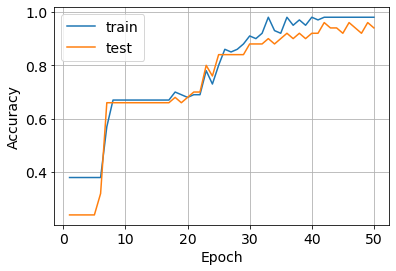

In [13]:
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

Also let's vizualize loss curves for train and test data.

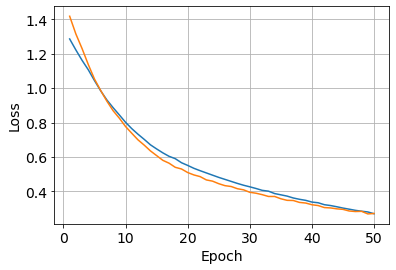

In [14]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

## Evaluation

### Test Accuracy

Let's check accuracy of the trained model for the test data.

In [15]:
test_correct_count = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():   # disable autograd for saving memory usage
    model.eval()        # set model to evaluation mode

    for x_batch, y_batch in test_loader:      # take mini batch data from test_loader 

        ###----- added to use GPU, 2022.9.30 -----###
        x_batch = x_batch.to(device)    # load batch data on GPU
        y_batch = y_batch.to(device)    # load batch data on GPU
        ###---------------------------------------###

        p_batch = model(x_batch)              # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
        test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        ### ----- modified to use GPU, 2022.9.30 ----- ###
        y_test_all = np.append(y_test_all, y_batch.cpu().numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.cpu().numpy())  # append p_batch_label in p_label_all
        ### ------------------------------------------ ###

test_accuracy = test_correct_count/len(xy_test)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.940


### Confusion Matrix

It is also good to check the confusion matrix to know the accuracies for each categories.

Text(0.5, 1.0, 'confusion matrix')

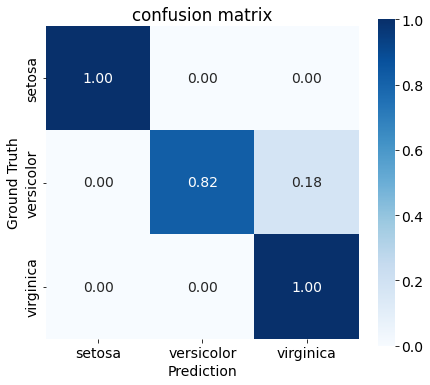

In [16]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(7,6))
labels = iris_data["target_names"]

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=labels, yticklabels=labels, square=True)

plt.ylabel("Ground Truth")
plt.xlabel("Prediction")
plt.title("confusion matrix")

## Prediction with New Data
Let's say we got a new input data, i.e. four feature values of a new unknown sample.

In [17]:
# unknown sample data
sepal_l = 3.0
sepal_w = 2.0
petal_l = 1.0
petal_w = 0.5

x = [sepal_l, sepal_w, petal_l, petal_w]
x = torch.tensor([x], dtype=torch.float32)
print(x)

tensor([[3.0000, 2.0000, 1.0000, 0.5000]])


We can make a prediction for this new sample with the trained model. Note that we apply `nn.Softmax()`function to the predicted values. `nn.Softmax()` is defined by,

$\displaystyle \mathrm{Softmax}(x_i) = \exp(x_i)/\sum_{j=0}^{N-1}\exp(x_j)$

This rescales predicted values so that ranging from 0 to 1 and sum to 1.  We can take these rescaled values as probabilities for three Iris types.

In [18]:
with torch.no_grad():

    ###----- added to use GPU, 2022.9.30 -----###
    x = x.to(device)
    ###---------------------------------------###      
    
    pred = model(x)
    print("pred =", pred)

    ###----- added to use GPU, 2022.9.30 -----###
    pred = pred.to(device)
    ###---------------------------------------### 
    
    softmax = nn.Softmax()
    prob = softmax(pred[0])
    print("prob =", prob)

pred = tensor([[ 1.6426,  0.7224, -2.3883]], device='cuda:0')
prob = tensor([0.7061, 0.2813, 0.0125], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [19]:
print("Probablity")
print(f"setosa {prob[0].item():.1%}")
print(f"vesicolor {prob[1].item():.1%}")
print(f"virginica {prob[2].item():.1%}")

Probablity
setosa 70.6%
vesicolor 28.1%
virginica 1.3%


<a name="model-visualization"></a>
## Model Visualization
There are a couple of ways to visualize PyTorch model as shown in the examples below. 

In order to see the examples below, please run this notebook from the beginning since the model defined above sections will be used in the examples.

### Example 1
The list of the neural network layers in the model can be visualized using `torchinfo` package.  The `torchinfo` is not available in the Google Colab by default, but you can install it by the pip command. 

In [20]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Then we can see the layer list in the model.

In [22]:
from torchinfo import summary

for x_batch, _ in train_loader:
    break


input_shape = x_batch.shape

print("input data shape:", input_shape)
summary(model, input_shape)

input data shape: torch.Size([5, 4])


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [5, 3]                    --
├─Sequential: 1-1                        [5, 3]                    --
│    └─Linear: 2-1                       [5, 10]                   50
│    └─ReLU: 2-2                         [5, 10]                   --
│    └─Linear: 2-3                       [5, 3]                    33
Total params: 83
Trainable params: 83
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Example 2
The computation graph of the model can be visualized using `torchviz` package.  The `torchviz` is not available in the Google Colab by default, but you can install it by the pip command. 

In [23]:
! pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=3e365096b750399d4fbae32ffd081aa30cfff4dffd64dd572915f5b2bc59ab29
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


Then we can see the computation graph of the model.

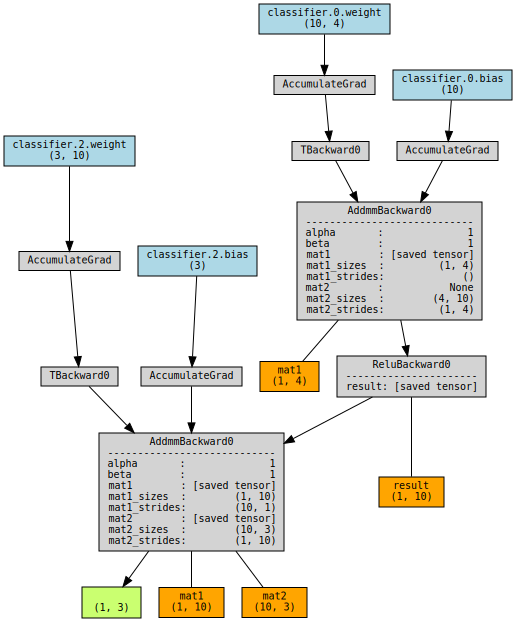

In [24]:
from torchviz import make_dot

# In case we have an input data like x=[sepal_l, sepal_w, petal_l, petal_w]
x = torch.randn(1,4).to(device)

y = model(x)

make_dot(y, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

### Example 3
We can see the values of weights and biases in the linear layers as shown below.

First linear layer (hidden layer) has 10 neurons which are all connected to 4 neurons in the input layer. Therefore, number of weights in this layer will be 40 (4x10) in total. 

Second linear layer (output layer) has 3 neurons which are all connected to 10 neurons in the hidden layer. Therefore number of weights in this layer will be 30 (10x3) in total.

Every single neuron has a bias. Therefore we have 10 and 3 biases in the first and the second linear layers, respectively.

Number of trainable parameters, i.e. weights and biases, in this model are 40+30+10+3=83.

In [25]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.data)
        print("\n")

classifier.0.weight
tensor([[ 0.2451,  0.2261,  0.4096, -0.0650],
        [ 0.3307,  0.5694, -0.6113, -0.1224],
        [ 0.2716, -0.1739,  0.0668,  0.1802],
        [ 0.4759,  0.2812, -0.4999, -0.6387],
        [-0.1060, -0.1379,  0.7836,  1.1823],
        [ 0.2031,  0.8129, -0.3640, -0.7123],
        [ 0.0655,  0.6011,  0.0400, -0.5518],
        [-0.2967,  0.2392, -0.2611, -0.4830],
        [-0.1240,  0.2647, -0.2136, -0.5760],
        [-0.4739,  0.4746, -0.2750, -0.2311]], device='cuda:0')


classifier.0.bias
tensor([ 0.3554,  0.0616,  0.3496,  0.3584,  0.1123, -0.0192,  0.0857, -0.0462,
         0.0023,  0.2943], device='cuda:0')


classifier.2.weight
tensor([[-0.3162,  0.5557, -0.1036,  0.6963, -0.6561,  0.4730,  0.3273,  0.1741,
         -0.2221, -0.2528],
        [-0.0308, -0.1172,  0.1419,  0.2352,  0.0631,  0.1398,  0.1941, -0.2657,
         -0.1107,  0.1467],
        [ 0.2294, -0.8544, -0.0560, -0.6705,  0.3572, -0.2787, -0.1141,  0.1027,
          0.1468, -0.0794]], device='

## Conclusion

That's it for this week. We have learned very basics of deep learning. Now you could try to change some hyper parameters listed below and see how the result changes.



* batch size in data loader
*   number of neurons in hidden layer
*   number of hidden layers
*  learning rate of optimizers
* type of optimizers
* number of epochs
* etc.


